Este colab fue desarrollado por Arnold Charry Armero.

# K-Means Clustering

El K-Means Clustering es una técnica de aprendizaje no supervisado que busca agrupar observaciones similares en función de sus características dentro de un conjunto de $K$ clústeres. Este algoritmo utiliza una métrica de distancia (comúnmente la distancia euclidiana) para evaluar la cercanía entre las observaciones y los centroides que representan a cada clúster.

El proceso consiste en seleccionar de manera aleatoria $K$ centroides iniciales dentro del espacio de los datos. Luego, cada observación se asigna al clúster cuyo centroide sea el más cercano. Una vez que todas las observaciones han sido asignadas, se recalculan los centroides tomando la media aritmética de las coordenadas de los puntos pertenecientes a cada clúster. Este procedimiento se repite hasta que los centroides dejan de cambiar significativamente o las asignaciones de los puntos permanecen estables. Matemáticamente, el algoritmo busca minimizar la función de costo o inercia total, definida como:

$$ \text{argmin}\sum_{k=1}^{K}\frac{1}{\left | C_{K}\right |}\cdot \sum_{x\in C_{K}}^{}\left\| x_{i}-\mu_{k}\right\|^{2} $$

Que asignando los puntos al clúster más cercano se obtiene,

$$ C_{K}^{t}=\left\{ x_{i}: \left\| x_{i} - \mu_{k}^{t}\right\|^{2} \leq \left\| x_{i} - \mu_{j}^{t}\right\|^{2} \forall j, 1\leq j\leq K\right\} $$

Y, actualizando los centroides, se obtiene la siguiente ecuación,

$$ μ_{k}^{t+1}= \frac{1}{\left | C_{k}^{t}\right |}\cdot \sum_{x \in C_{k}}^{}x_{i} $$

Donde,
- $K$ es el número de clústeres,
- $C_k$ representa el conjunto de observaciones asignadas al clúster $k$,
- $\mu_k$ es el centroide (vector medio) del clúster $k$.

Otra cuestión importante es que para seleccionar la cantidad de clústeres óptima, hay varias estrategias entre las que se encuentran el Método del Codo, la técnica de la silueta y el índice de Davies-Bouldin. En este colab se revisarán las dos primeras técnicas.

Para el Método del Codo, se calcula la suma de las distancias cuadradas de cada punto a su centroide. A medida que se incrementa el número de clústeres, esta suma (también llamada inercia) disminuye. El número óptimo de clústeres se encuentra en el punto donde la reducción de inercia comienza a ser marginal, formando visualmente un “codo” en la gráfica. La ecuación correspondiente es:


$$ \sum_{k=1}^{K}\sum_{x\in C_{K}}^{}\left\| x_{i}-\mu_{k}\right\|^{2} $$

Ahora se continúa con la implementación en código,

In [ ]:
# Se importan las librerias
import math as mt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from pandas.api.types import is_numeric_dtype, is_object_dtype, is_string_dtype

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/Bases de Datos/Mall_Customers.csv')

In [ ]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Se elimina la fila de CustomerID,

In [ ]:
df.drop('CustomerID', axis = 1, inplace = True)

In [ ]:
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


Primero se analiza la base de datos,

In [ ]:
# Se verifica la cantidad de datos
df.shape

(200, 4)

Se puede observar que hay 200 filas. Se observará de qué tipo son estos valores y si hay faltantes.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Genre                   200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [ ]:
# Se verifica el tema de los faltantes
df.isnull().sum()[df.isnull().sum() != 0]

,0


Ahora se analizan las características con datos relevantes,

In [ ]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


## Preprocesamiento de Datos

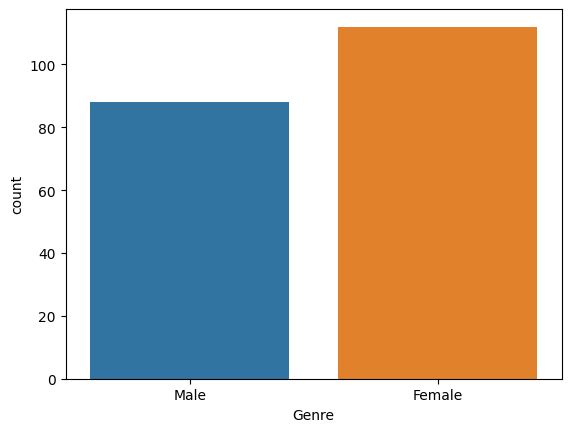

In [ ]:
# Gráfico de barras por cada clase
sns.countplot(data=df,x='Genre', hue='Genre')
plt.show()

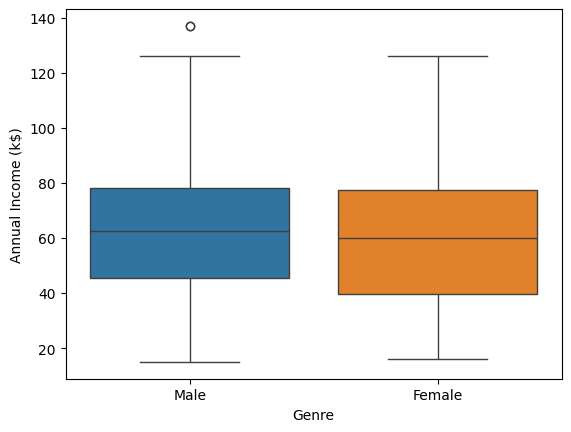

In [ ]:
# Gráfico de caja
sns.boxplot(x='Genre',y='Annual Income (k$)',data=df, hue='Genre')
plt.show()

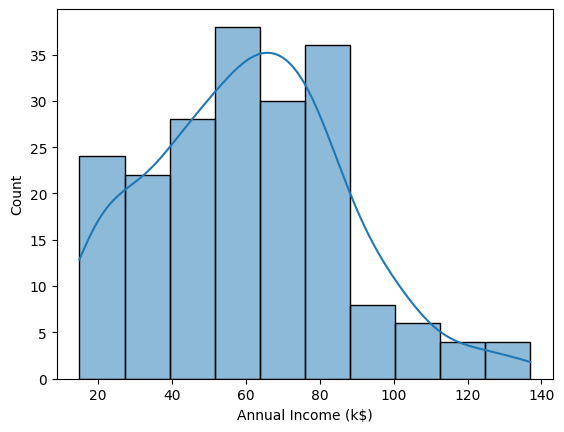

In [ ]:
sns.histplot(data = df, x = 'Annual Income (k$)', kde = True)
plt.show()

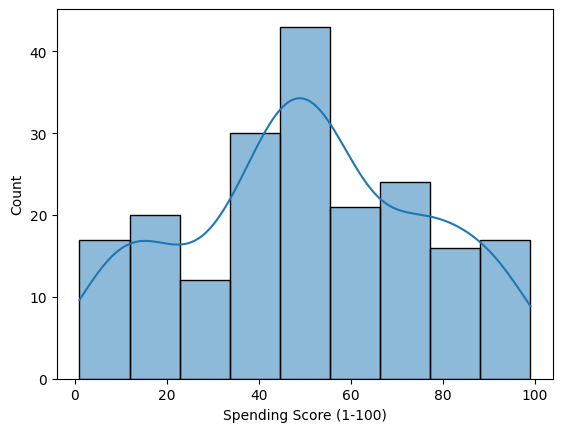

In [ ]:
sns.histplot(data = df, x = 'Spending Score (1-100)', kde = True)
plt.show()

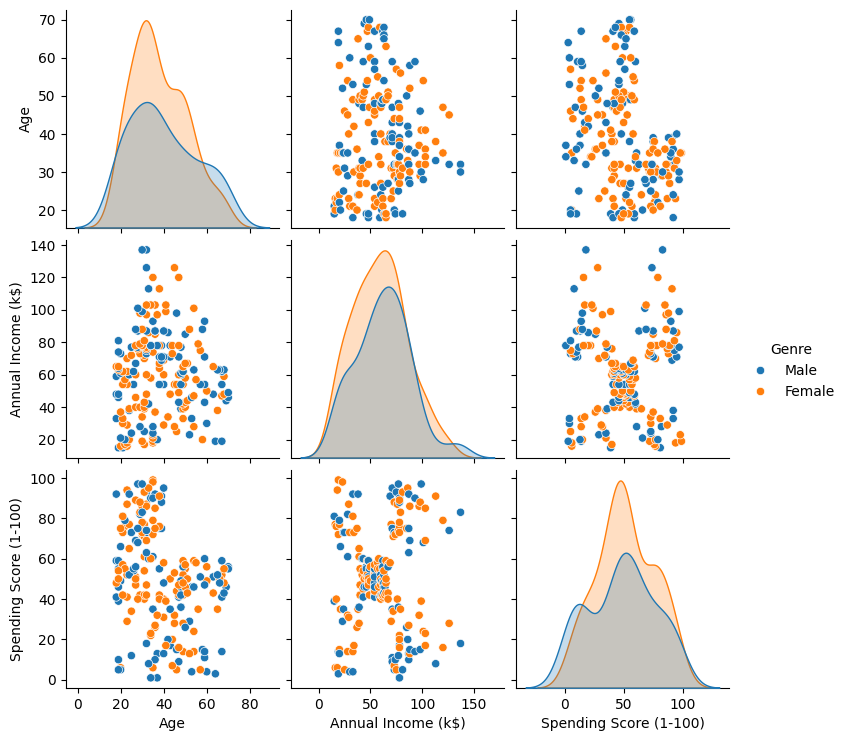

In [ ]:
sns.pairplot(df, hue='Genre')
plt.show()

Se realizará un análisis para las dos variables más importantes, las cuales son Annual Income (k$) y Spending Score. Posteriormente de este análisis, se hará un análisis para toda la base de datos.

In [ ]:
X = df.iloc[:, 2:].values

In [ ]:
# Escalado de datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Visualizar el array X
print(X)

[[-1.73899919 -0.43480148]
 [-1.73899919  1.19570407]
 [-1.70082976 -1.71591298]
 [-1.70082976  1.04041783]
 [-1.66266033 -0.39597992]
 [-1.66266033  1.00159627]
 [-1.62449091 -1.71591298]
 [-1.62449091  1.70038436]
 [-1.58632148 -1.83237767]
 [-1.58632148  0.84631002]
 [-1.58632148 -1.4053405 ]
 [-1.58632148  1.89449216]
 [-1.54815205 -1.36651894]
 [-1.54815205  1.04041783]
 [-1.54815205 -1.44416206]
 [-1.54815205  1.11806095]
 [-1.50998262 -0.59008772]
 [-1.50998262  0.61338066]
 [-1.43364376 -0.82301709]
 [-1.43364376  1.8556706 ]
 [-1.39547433 -0.59008772]
 [-1.39547433  0.88513158]
 [-1.3573049  -1.75473454]
 [-1.3573049   0.88513158]
 [-1.24279661 -1.4053405 ]
 [-1.24279661  1.23452563]
 [-1.24279661 -0.7065524 ]
 [-1.24279661  0.41927286]
 [-1.20462718 -0.74537397]
 [-1.20462718  1.42863343]
 [-1.16645776 -1.7935561 ]
 [-1.16645776  0.88513158]
 [-1.05194947 -1.7935561 ]
 [-1.05194947  1.62274124]
 [-1.05194947 -1.4053405 ]
 [-1.05194947  1.19570407]
 [-1.01378004 -1.28887582]
 

## Aprendizaje No Supervisado

Ahora se selecciona cuál es la cantidad de clústers óptima por medio del Método del Codo y del Método de la Silueta. Con base en esto, se toma la decisión de segmentar los datos por tipo de grupo.

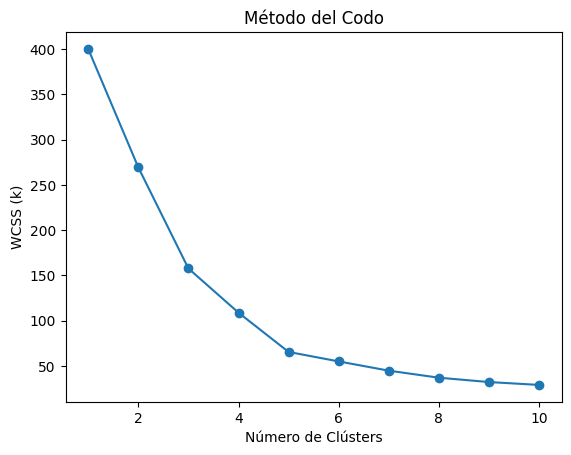

In [ ]:
wcss = []

for k in range(1, 11):
  kmeans = KMeans(n_clusters = k, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker = "o")
plt.title("Método del Codo")
plt.xlabel("Número de Clústers")
plt.ylabel("WCSS (k)")
plt.show()

## Segmentación con K-Means

Ahora que se tiene que el número de Clústeres óptimo es de 5, se va a graficar mirando cada categoría con sus respectivos datos.

In [ ]:
kmeans = KMeans(n_clusters = 5, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(X)

In [ ]:
# Se desescalan los datos y los centroides
X_original = scaler.inverse_transform(X)
centroids_original = scaler.inverse_transform(kmeans.cluster_centers_)

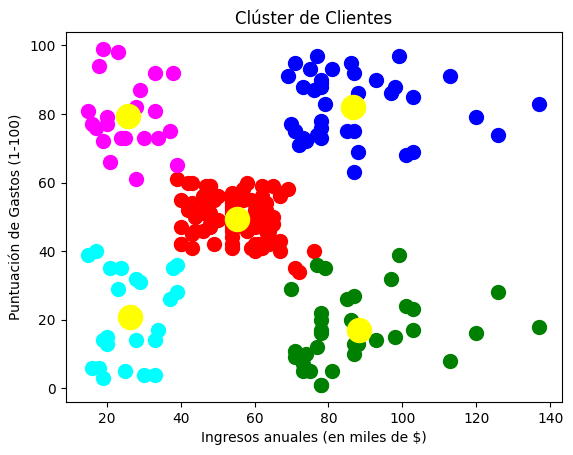

In [ ]:
# Visualización de los clusters
plt.scatter(X_original[y_kmeans == 0, 0], X_original[y_kmeans == 0, 1], s = 100, c = "red", label = "Cautos")
plt.scatter(X_original[y_kmeans == 1, 0], X_original[y_kmeans == 1, 1], s = 100, c = "blue", label = "Estándar")
plt.scatter(X_original[y_kmeans == 2, 0], X_original[y_kmeans == 2, 1], s = 100, c = "green", label = "Objetivo")
plt.scatter(X_original[y_kmeans == 3, 0], X_original[y_kmeans == 3, 1], s = 100, c = "cyan", label = "Descuidados")
plt.scatter(X_original[y_kmeans == 4, 0], X_original[y_kmeans == 4, 1], s = 100, c = "magenta", label = "Conservadores")
plt.scatter(centroids_original[:, 0], centroids_original[:, 1], s = 300, c = "yellow", label = "Centroides")
plt.title("Clúster de Clientes")
plt.xlabel("Ingresos anuales (en miles de $)")
plt.ylabel("Puntuación de Gastos (1-100)")
plt.show()

## Más de Dos Variables

Ahora se realiza el mismo proceso, pero para todas las características,

In [ ]:
# Obtenemos las características
X = df.iloc[:, :].values

In [ ]:
# Se detectan las columnas categóricas
cat_cols = df.select_dtypes(include=['object', 'category'])
cat_indices = [df.columns.get_loc(col) for col in cat_cols]

# Se detectan las columnas numéricas
num_indices = [i for i in range(df.shape[1]) if i not in cat_indices]

# Se crea el transformador
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(drop='first',sparse_output=False, dtype=int), cat_indices),
                  ('scaler', StandardScaler(), num_indices)],
    remainder='passthrough')


# Se aplica al array X
X = np.array(ct.fit_transform(X))

In [ ]:
# Visualizar el array X
print(X)

[[ 1.         -1.42456879 -1.73899919 -0.43480148]
 [ 1.         -1.28103541 -1.73899919  1.19570407]
 [ 0.         -1.3528021  -1.70082976 -1.71591298]
 [ 0.         -1.13750203 -1.70082976  1.04041783]
 [ 0.         -0.56336851 -1.66266033 -0.39597992]
 [ 0.         -1.20926872 -1.66266033  1.00159627]
 [ 0.         -0.27630176 -1.62449091 -1.71591298]
 [ 0.         -1.13750203 -1.62449091  1.70038436]
 [ 1.          1.80493225 -1.58632148 -1.83237767]
 [ 0.         -0.6351352  -1.58632148  0.84631002]
 [ 1.          2.02023231 -1.58632148 -1.4053405 ]
 [ 0.         -0.27630176 -1.58632148  1.89449216]
 [ 0.          1.37433211 -1.54815205 -1.36651894]
 [ 0.         -1.06573534 -1.54815205  1.04041783]
 [ 1.         -0.13276838 -1.54815205 -1.44416206]
 [ 1.         -1.20926872 -1.54815205  1.11806095]
 [ 0.         -0.27630176 -1.50998262 -0.59008772]
 [ 1.         -1.3528021  -1.50998262  0.61338066]
 [ 1.          0.94373197 -1.43364376 -0.82301709]
 [ 0.         -0.27630176 -1.43

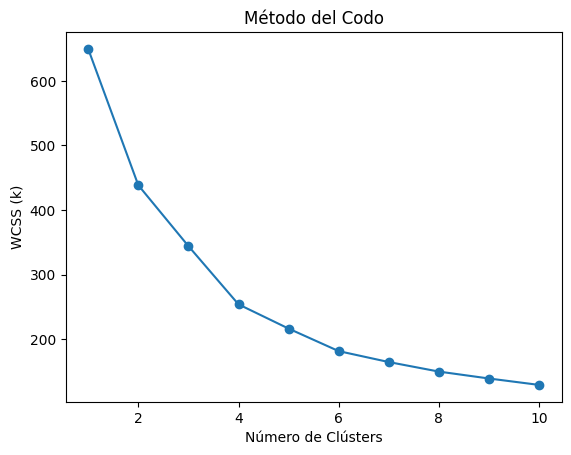

In [ ]:
wcss = []

for k in range(1, 11):
  kmeans = KMeans(n_clusters = k, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker = "o")
plt.title("Método del Codo")
plt.xlabel("Número de Clústers")
plt.ylabel("WCSS (k)")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 4, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
cluster_labels = kmeans.fit_predict(X)

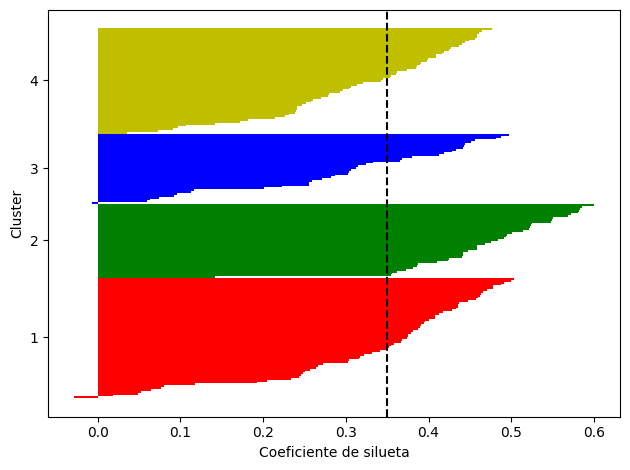

In [ ]:
k=4
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(X)
y_clusters = kmeans.labels_
cluster_labels = np.unique(y_clusters)

silueta_puntos= silhouette_samples(X, y_clusters, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
colores = ['r', 'g', 'b', 'y', 'o']
for i, c in enumerate(cluster_labels):
    silueta_puntos_c = silueta_puntos[y_clusters == c]
    silueta_puntos_c.sort()
    y_ax_upper += len(silueta_puntos_c)
    color = colores[i]
    plt.barh(range(y_ax_lower, y_ax_upper), silueta_puntos_c, height=1.0,
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(silueta_puntos_c)

silueta_promedio = np.mean(silueta_puntos)
plt.axvline(silueta_promedio, color="black", linestyle="--")

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Coeficiente de silueta')

plt.tight_layout()
plt.show()

In [ ]:
# Se añaden los clusters a los datos originales
df['Cluster'] = cluster_labels

In [ ]:
# Se visualizan los datos con clusters
display(df)

,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,Male,19,15,39,3
1,Male,21,15,81,3
2,Female,20,16,6,3
3,Female,23,16,77,3
4,Female,31,17,40,3
...,...,...,...,...,...
195,Female,35,120,79,1
196,Female,45,126,28,2
197,Male,32,126,74,1
198,Male,32,137,18,2


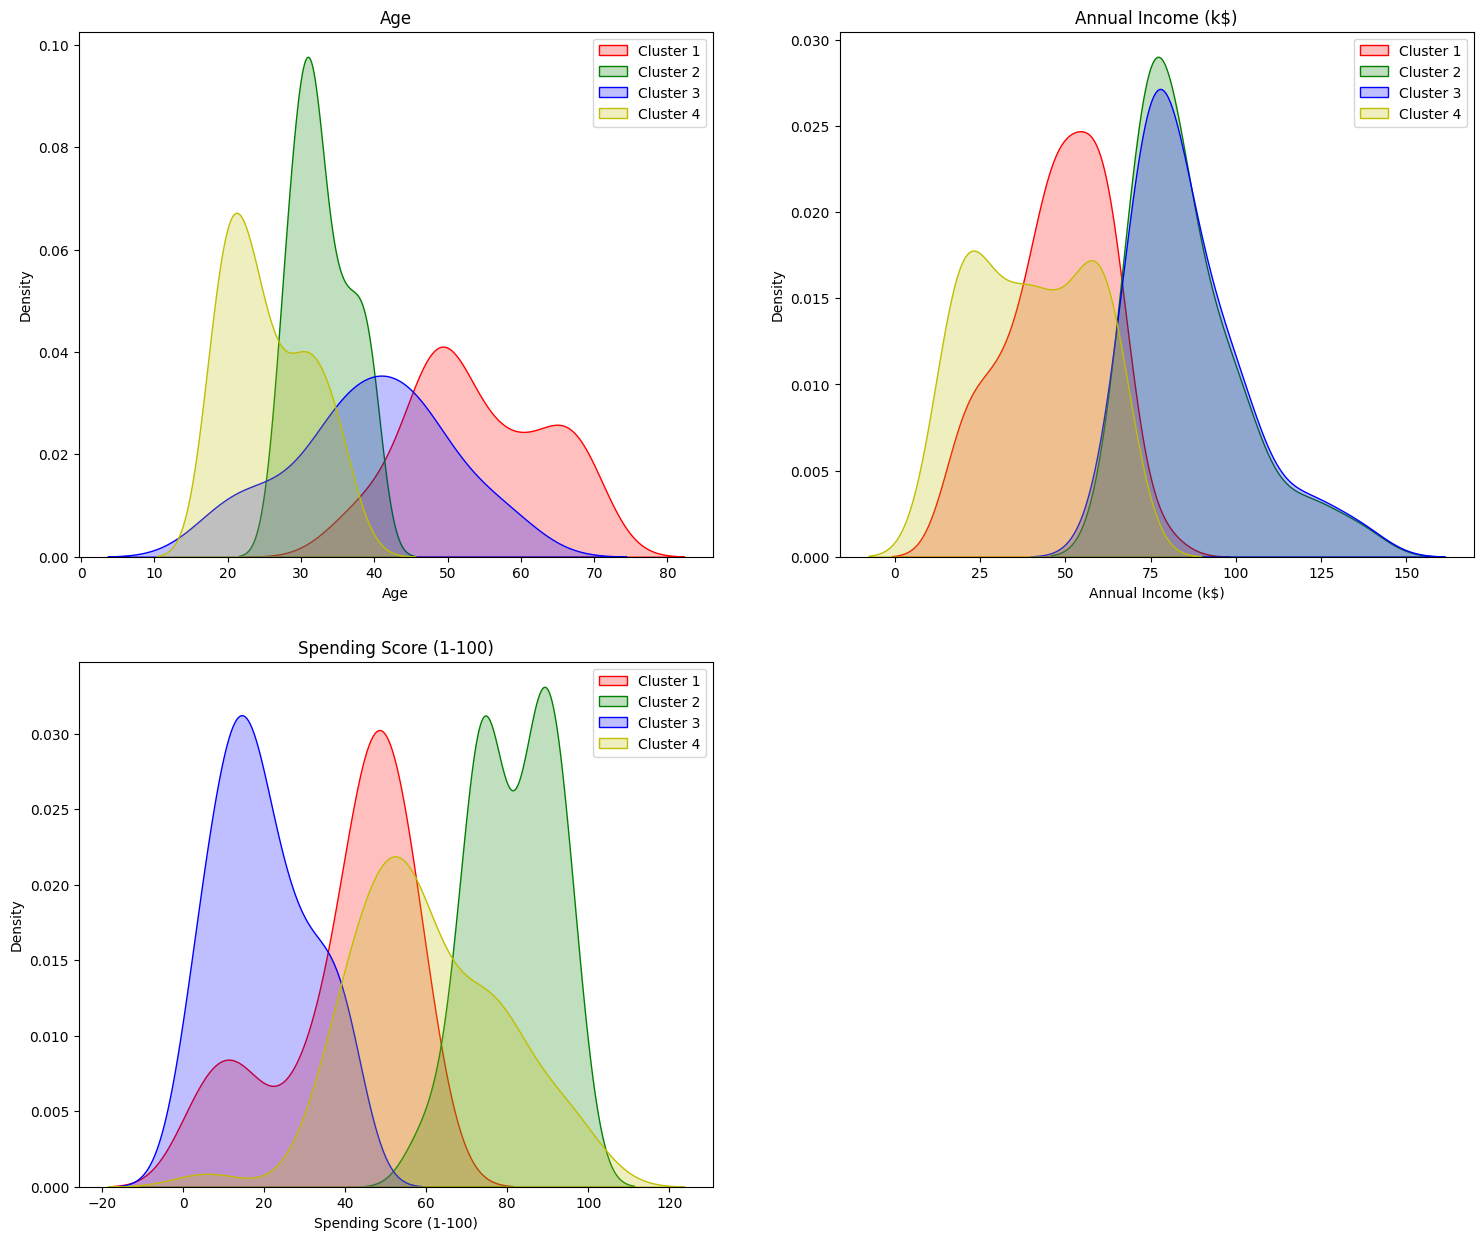

In [ ]:
num_cols = df.select_dtypes(include=np.number).columns
fig = plt.figure(figsize=(18,15))
i=1
for var in num_cols[:-1]:
    ax = fig.add_subplot(mt.ceil(len(num_cols[:-1])/2), 2, i)
    sns.kdeplot(df.loc[df.Cluster==0][var], fill=True, color='r', ax=ax);
    sns.kdeplot(df.loc[df.Cluster==1][var], fill=True, color='g', ax=ax);
    sns.kdeplot(df.loc[df.Cluster==2][var], fill=True, color='b', ax=ax);
    sns.kdeplot(df.loc[df.Cluster==3][var], fill=True, color='y', ax=ax)
    plt.title(var)
    plt.legend(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
    i+=1

Ahora se mira la interpretación para cada una de las variables para tener una mayor idea de los clústers.

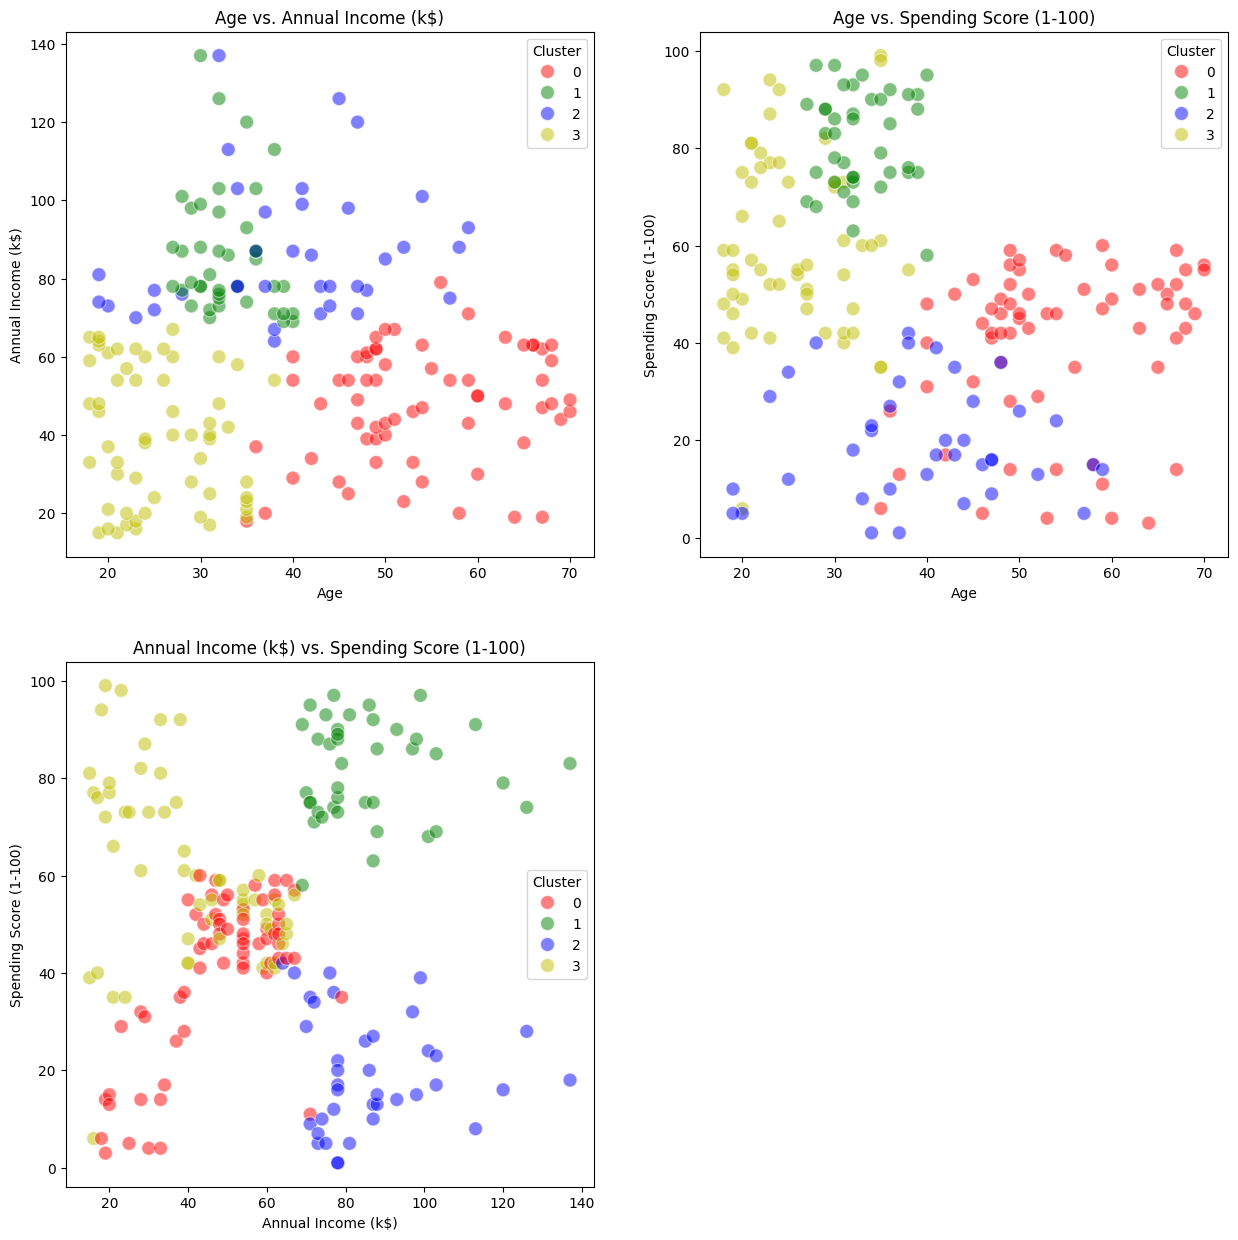

In [ ]:
fig = plt.figure(figsize=(15,15))
colorPalette = ["r", "g", "b", "y"]
ax = fig.add_subplot(2, 2, 1)
sns.scatterplot(x="Age", y="Annual Income (k$)", hue="Cluster", data=df, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Age vs. Annual Income (k$)")
ax = fig.add_subplot(2, 2, 2)
sns.scatterplot(x="Age", y="Spending Score (1-100)", hue="Cluster", data=df, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Age vs. Spending Score (1-100)")
ax = fig.add_subplot(2, 2, 3)
sns.scatterplot(x="Annual Income (k$)", y="Spending Score (1-100)", hue="Cluster", data=df, ax=ax, palette=colorPalette, s=100, alpha=0.5)
plt.title("Annual Income (k$) vs. Spending Score (1-100)")
plt.show()

## Referencias

*   Jacinto, V. R. (2024). Machine learning: Fundamentos, algoritmos y aplicaciones para los negocios, industria y finanzas. Ediciones Díaz de Santos.
*   James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). An Introduction to Statistical Learning: with Applications in R. https://link.springer.com/content/pdf/10.1007/978-1-0716-1418-1.pdf
*   Mall customers. (2019, April 29). Kaggle. https://www.kaggle.com/datasets/kandij/mall-customers